In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
quality_df = pd.read_csv("threshold_min_quality_indicators.csv")
look_up_table = pd.read_csv("re_eval_quality_indicators.csv")

In [3]:
def get_mean_of_best(df, approach):
    delivery_rate_mean = df[df['approach'] ==approach]['delivery_rate_best'].mean()
    utilization_rate_mean = df[df['approach'] ==approach]['utilization_rate_best'].mean()
    num_risk_mean = df[df['approach'] ==approach]['num_risk_best'].mean()
    
    return np.array([delivery_rate_mean, utilization_rate_mean, num_risk_mean])

def from_df_to_numpy(df):
    delivery_rate_worst = df['delivery_rate_best'].to_list()
    utilization_rate_worst = df['utilization_rate_best'].to_list()
    num_risk_worst = df['num_risk_best'].to_list()

    return np.array([delivery_rate_worst, utilization_rate_worst, num_risk_worst])
    

In [4]:
generations = ['21', '42', '63', '84']
H = [1,2,3,4]
# M = [i for i in range(1, int(generation))]
data = []

for idx in range(1, 20+1):
    now_approach = f'standard_H_0_M_{idx}'
    temp = get_mean_of_best(df=quality_df, approach=now_approach)
    row = {'approach' : now_approach, 'delivery_rate_best' : temp[0], 'utilization_rate_best' : temp[1], 'num_risk_best' : temp[2], 'all_obj_mean' : np.mean(temp)}
    data.append(row)

for idx, generation in enumerate(generations):
    M = [i for i in range(1, int(generation))]
    using_H = H[idx]
    for using_M in M:
        now_approach = f'incremental-data_lab28_special_utilization_model12.pth_H_{using_H}_M_{using_M}'
        temp = get_mean_of_best(df=quality_df, approach=now_approach)
        row = {'approach' : now_approach, 'delivery_rate_best' : temp[0], 'utilization_rate_best' : temp[1], 'num_risk_best' : temp[2], 'all_obj_mean' : np.mean(temp)}
        data.append(row)

data = pd.DataFrame(data)

data.to_csv("min_threshold.csv", index=False)

In [5]:
get_best_individual = pd.read_csv("min_threshold.csv")

In [8]:
# delivery_rate_threshold_set = [1, 0.5, 0.2, 0.15, 0.012]
# utilization_rate_threshold_set = [1, 0.5, 0.2, 0.15, 0.1]
# num_risk_threshold_set = [3, 2, 1, 0.5, 0.3, 0.1]
# window_set = [13, 10, 5, 3, 1]

delivery_rate_threshold_set = np.linspace(-10, -0.1, 30) # percentage
utilization_rate_threshold_set = np.linspace(-10, -0.1, 30) # percentage
num_risk_threshold_set = np.linspace(-50, -10, 20) # percentage
window_set = [10, 9, 8, 7, 6, 5, 4, 3]

generations = ['standard', '21', '42', '63', '84']
H = [1,2,3,4]
# M = [i for i in range(1, int(generation))]
data = []
count = 0
for window in window_set:
    for delivery_rate_threshold in delivery_rate_threshold_set:
        for utilization_rate_threshold in utilization_rate_threshold_set:
            for num_risk_threshold in num_risk_threshold_set:
                row = {}
                for idx, generation in enumerate(generations):
                    if generation == 'standard':
                        for standard_generation in range(window+1,21):
                            row[f'standard_Stop_Generation'] = -1
                            row[f'standard_reeval_IGD'] = -1
                            row[f'standard_budget'] = -1

                            based_approach = f'standard_H_0_M_{standard_generation - window}' 
                            now_approach = f'standard_H_0_M_{standard_generation}'
                            
                            based_data = get_best_individual[get_best_individual['approach'] == based_approach]
                            now_data = get_best_individual[get_best_individual['approach'] == now_approach]
                            
                            based_obj = from_df_to_numpy(based_data)
                            now_obj = from_df_to_numpy(now_data)        
                            assert np.where(now_obj <= based_obj, 1, 0).all()
                            
                            change_obj = (now_obj - based_obj)/np.abs(based_obj)*100
                            if (change_obj[0] > delivery_rate_threshold) & (change_obj[1] > utilization_rate_threshold) & (change_obj[2] > num_risk_threshold):
                                row[f'standard_Stop_Generation'] = standard_generation
                                row[f'standard_reeval_IGD'] = look_up_table[look_up_table['approach'] == now_approach]['IGD'].mean()
                                row[f'standard_budget'] = standard_generation*12 + 12
                            else:
                                row[f'standard_Stop_Generation'] = standard_generation
                                row[f'standard_reeval_IGD'] = look_up_table[look_up_table['approach'] == now_approach]['IGD'].mean()
                                row[f'standard_budget'] = standard_generation*12 + 12
                    else:
                        M = [i for i in range(window+1, int(generation))]
                        using_H = H[idx-1]
                        row[f'H_{using_H}_Stop_Generation'] = -1
                        row[f'H_{using_H}_reeval_IGD'] = -1
                        row[f'H_{using_H}_budget'] = -1
                        for using_M in M:
                            based_approach = f'incremental-data_lab28_special_utilization_model12.pth_H_{using_H}_M_{using_M - window}' 
                            now_approach = f'incremental-data_lab28_special_utilization_model12.pth_H_{using_H}_M_{using_M}'
                            
                            based_data = get_best_individual[get_best_individual['approach'] == based_approach]
                            now_data = get_best_individual[get_best_individual['approach'] == now_approach]
                            
                            based_obj = from_df_to_numpy(based_data)
                            now_obj = from_df_to_numpy(now_data)        
                            assert np.where(now_obj <= based_obj, 1, 0).all()
                            
                            change_obj = (now_obj - based_obj)/np.abs(based_obj)*100
                            if (change_obj[0] > delivery_rate_threshold) & (change_obj[1] > utilization_rate_threshold) & (change_obj[2] > num_risk_threshold):
                                row[f'H_{using_H}_Stop_Generation'] = using_M
                                row[f'H_{using_H}_reeval_IGD'] = look_up_table[look_up_table['approach'] == now_approach]['IGD'].mean()
                                if using_M < using_H*2:
                                    row[f'H_{using_H}_budget'] = 32
                                elif (using_M >= using_H*2) & (using_M < using_H*5):
                                    row[f'H_{using_H}_budget'] = 63
                                elif (using_M >= using_H*5) & (using_M < using_H*10):
                                    row[f'H_{using_H}_budget'] = 126
                                elif (using_M >= using_H*10) & (using_M < using_H*21):
                                    row[f'H_{using_H}_budget'] = 252
                                break
                            else:
                                row[f'H_{using_H}_Stop_Generation'] = using_M
                                row[f'H_{using_H}_reeval_IGD'] = look_up_table[look_up_table['approach'] == now_approach]['IGD'].mean()
                                if using_M < using_H*2:
                                    row[f'H_{using_H}_budget'] = 32
                                elif (using_M >= using_H*2) & (using_M < using_H*5):
                                    row[f'H_{using_H}_budget'] = 63
                                elif (using_M >= using_H*5) & (using_M < using_H*10):
                                    row[f'H_{using_H}_budget'] = 126
                                elif (using_M >= using_H*10) & (using_M < using_H*21):
                                    row[f'H_{using_H}_budget'] = 252
                                
                row['delivery_rate_threshold'] = delivery_rate_threshold
                row['utilization_rate_threshold'] = utilization_rate_threshold
                row['num_risk_threshold'] = num_risk_threshold
                row['window'] = window
                data.append(row)


data = pd.DataFrame(data)
data.to_csv("stop_criterion.csv", index=False)
data

,standard_Stop_Generation,standard_reeval_IGD,standard_budget,H_1_Stop_Generation,H_1_reeval_IGD,H_1_budget,H_2_Stop_Generation,H_2_reeval_IGD,H_2_budget,H_3_Stop_Generation,H_3_reeval_IGD,H_3_budget,H_4_Stop_Generation,H_4_reeval_IGD,H_4_budget,delivery_rate_threshold,utilization_rate_threshold,num_risk_threshold,window
0,20,0.511861,252,20,0.767414,252,14,0.812298,126,16,0.864584,126,18,0.715462,63,-10.0,-10.0,-50.000000,10
1,20,0.511861,252,20,0.767414,252,14,0.812298,126,17,0.855049,126,18,0.715462,63,-10.0,-10.0,-47.894737,10
2,20,0.511861,252,20,0.767414,252,15,0.787107,126,17,0.855049,126,18,0.715462,63,-10.0,-10.0,-45.789474,10
3,20,0.511861,252,20,0.767414,252,15,0.787107,126,17,0.855049,126,18,0.715462,63,-10.0,-10.0,-43.684211,10
4,20,0.511861,252,20,0.767414,252,15,0.787107,126,18,0.847060,126,18,0.715462,63,-10.0,-10.0,-41.578947,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143995,20,0.511861,252,17,0.770080,252,16,0.774338,126,16,0.864584,126,13,0.747499,63,-0.1,-0.1,-18.421053,3
143996,20,0.511861,252,18,0.763117,252,16,0.774338,126,16,0.864584,126,13,0.747499,63,-0.1,-0.1,-16.315789,3
143997,20,0.511861,252,19,0.764070,252,16,0.774338,126,16,0.864584,126,13,0.747499,63,-0.1,-0.1,-14.210526,3
143998,20,0.511861,252,20,0.767414,252,20,0.787640,252,20,0.791855,126,13,0.747499,63,-0.1,-0.1,-12.105263,3


In [149]:
# data = pd.read_csv("stop_criterion.csv")
# data = data[(data['H_1_Stop_Generation'] != -1) & (data['H_2_Stop_Generation'] != -1) & (data['H_3_Stop_Generation'] != -1) & (data['H_4_Stop_Generation'] != -1) & (data['standard_Stop_Generation'] != -1)]
# data.to_csv("stop_criterion.csv", index=False)
# data

,standard_Stop_Generation,standard_reeval_IGD,standard_budget,H_1_Stop_Generation,H_1_reeval_IGD,H_1_budget,H_2_Stop_Generation,H_2_reeval_IGD,H_2_budget,H_3_Stop_Generation,H_3_reeval_IGD,H_3_budget,H_4_Stop_Generation,H_4_reeval_IGD,H_4_budget,delivery_rate_threshold,utilization_rate_threshold,num_risk_threshold,window
54000,20,0.397883,252,13,0.779197,252,11,0.829709,126,13,0.728322,63,12,0.887151,63,-10.0,-10.000000,-50.000000,7
54001,20,0.397883,252,13,0.779197,252,11,0.829709,126,13,0.728322,63,12,0.887151,63,-10.0,-10.000000,-47.894737,7
54020,20,0.397883,252,13,0.779197,252,11,0.829709,126,13,0.728322,63,12,0.887151,63,-10.0,-9.658621,-50.000000,7
54021,20,0.397883,252,13,0.779197,252,11,0.829709,126,13,0.728322,63,12,0.887151,63,-10.0,-9.658621,-47.894737,7
54040,20,0.397883,252,13,0.779197,252,11,0.829709,126,13,0.728322,63,12,0.887151,63,-10.0,-9.317241,-50.000000,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143993,20,0.397883,252,15,0.738569,252,12,0.808274,126,12,0.763155,63,13,0.861779,63,-0.1,-0.100000,-22.631579,3
143994,20,0.397883,252,15,0.738569,252,12,0.808274,126,12,0.763155,63,13,0.861779,63,-0.1,-0.100000,-20.526316,3
143995,20,0.397883,252,15,0.738569,252,12,0.808274,126,13,0.728322,63,13,0.861779,63,-0.1,-0.100000,-18.421053,3
143996,20,0.397883,252,15,0.738569,252,16,0.749805,126,13,0.728322,63,17,0.781305,63,-0.1,-0.100000,-16.315789,3


In [6]:
data = pd.read_csv("stop_criterion.csv")
data

,standard_Stop_Generation,standard_reeval_IGD,standard_budget,H_1_Stop_Generation,H_1_reeval_IGD,H_1_budget,H_2_Stop_Generation,H_2_reeval_IGD,H_2_budget,H_3_Stop_Generation,H_3_reeval_IGD,H_3_budget,H_4_Stop_Generation,H_4_reeval_IGD,H_4_budget,delivery_rate_threshold,utilization_rate_threshold,num_risk_threshold,window
0,20,0.511861,252,20,0.767414,252,14,0.812298,126,16,0.864584,126,18,0.715462,63,-10.0,-10.0,-50.000000,10
1,20,0.511861,252,20,0.767414,252,14,0.812298,126,17,0.855049,126,18,0.715462,63,-10.0,-10.0,-47.894737,10
2,20,0.511861,252,20,0.767414,252,15,0.787107,126,17,0.855049,126,18,0.715462,63,-10.0,-10.0,-45.789474,10
3,20,0.511861,252,20,0.767414,252,15,0.787107,126,17,0.855049,126,18,0.715462,63,-10.0,-10.0,-43.684211,10
4,20,0.511861,252,20,0.767414,252,15,0.787107,126,18,0.847060,126,18,0.715462,63,-10.0,-10.0,-41.578947,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143995,20,0.511861,252,17,0.770080,252,16,0.774338,126,16,0.864584,126,13,0.747499,63,-0.1,-0.1,-18.421053,3
143996,20,0.511861,252,18,0.763117,252,16,0.774338,126,16,0.864584,126,13,0.747499,63,-0.1,-0.1,-16.315789,3
143997,20,0.511861,252,19,0.764070,252,16,0.774338,126,16,0.864584,126,13,0.747499,63,-0.1,-0.1,-14.210526,3
143998,20,0.511861,252,20,0.767414,252,20,0.787640,252,20,0.791855,126,13,0.747499,63,-0.1,-0.1,-12.105263,3


In [12]:

H = ['H_1', 'H_2', 'H_3', 'H_4', 'standard']
matrix_budget = np.zeros((len(H), len(H)))
matrix_IGD = np.zeros((len(H), len(H)))
matrix_budget_IGD = np.zeros((len(H), len(H)))
matrix_diff_IGD = np.zeros((len(H), len(H)))
stop_gen_set = []
reeval_IGD_set = []
used_th_set = []
for r, H_first in enumerate(H):
    for c, H_second in enumerate(H):
        # print(f'{H_first}, {H_second}')
        compare_diff1_IGD = data[f'{H_first}_reeval_IGD'].mean()
        compare_diff2_IGD = data[f'{H_second}_reeval_IGD'].mean()
        matrix_diff_IGD[r,c] = (compare_diff2_IGD - compare_diff1_IGD)/compare_diff1_IGD

        for row_idx in range(data.shape[0]):
            row_data = data.iloc[row_idx]
            compare1_IGD = row_data[f'{H_first}_reeval_IGD']
            compare1_budget = row_data[f'{H_first}_budget']
            compare2_IGD = row_data[f'{H_second}_reeval_IGD']
            compare2_budget = row_data[f'{H_second}_budget']
            
            if compare1_budget < compare2_budget:
                matrix_budget[r,c] += 1
            if compare1_IGD < compare2_IGD:
                matrix_IGD[r,c] += 1
            if (compare1_budget < compare2_budget) & (compare1_IGD < compare2_IGD):
                matrix_budget_IGD[r,c] += 1
                if H_first == 'H_4':
                    stop_gen_set.append([row_data['H_1_Stop_Generation'], row_data['H_2_Stop_Generation'], row_data['H_3_Stop_Generation'], row_data['H_4_Stop_Generation'], row_data['standard_Stop_Generation']])
                    reeval_IGD_set.append([row_data['H_1_reeval_IGD'], row_data['H_2_reeval_IGD'], row_data['H_3_reeval_IGD'], row_data['H_4_reeval_IGD'], row_data['standard_reeval_IGD']])
                    used_th_set.append([row_data['delivery_rate_threshold'], row_data['utilization_rate_threshold'], row_data['num_risk_threshold'], row_data['window']])
                


In [67]:
import numpy as np
a = np.array(stop_gen_set)
np.save("stop_gen_set.npy", a) 
a = np.array(reeval_IGD_set)
np.save("reeval_IGD_set.npy", a)
a = np.array(used_th_set)
np.save("used_th_set.npy", a)

In [7]:
stop_gen_set = np.load("stop_gen_set.npy")
reeval_IGD_set = np.load("reeval_IGD_set.npy")
used_th_set = np.load("used_th_set.npy")

In [ ]:
# matrix_budget = matrix_budget/data.shape[0]
# matrix_IGD = matrix_IGD/data.shape[0]
# matrix_budget_IGD = matrix_budget_IGD/data.shape[0]

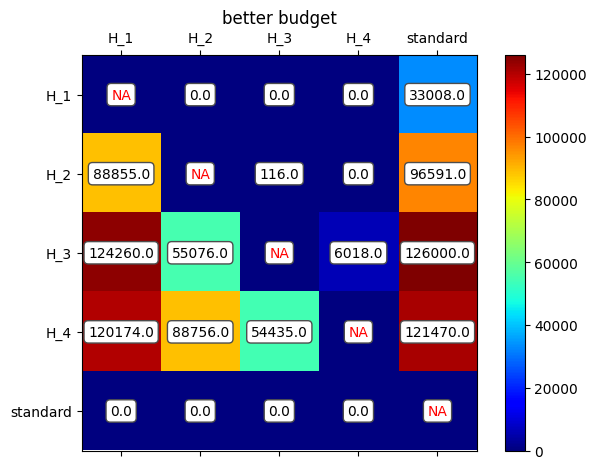

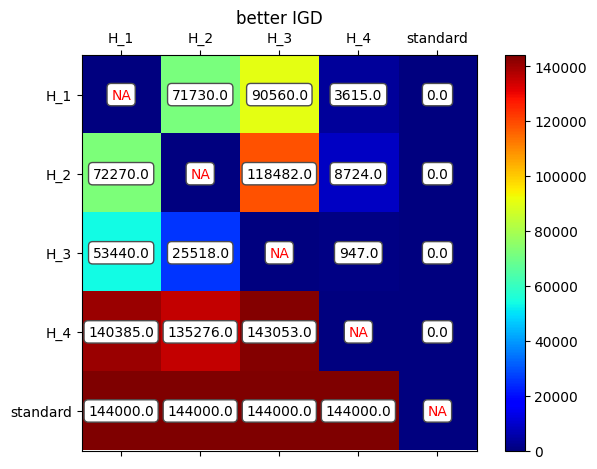

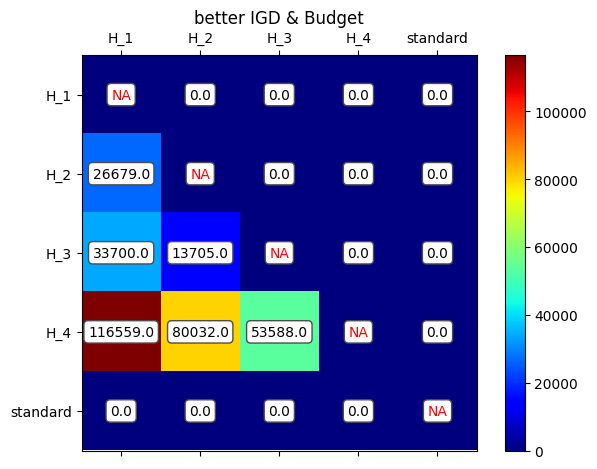

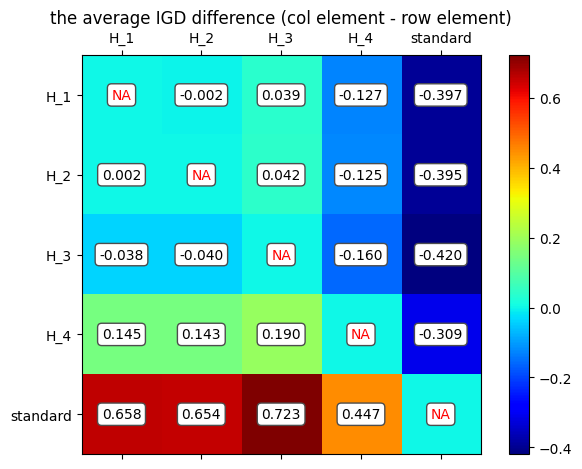

In [13]:
# plot matrix 
import matplotlib.pyplot as plt

os.makedirs('pic', exist_ok=True)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(matrix_budget, cmap=plt.cm.jet)
plt.colorbar(ax.imshow(matrix_budget, cmap=plt.cm.jet))

for (i, j), z in np.ndenumerate(matrix_budget):
    if i==j:
        ax.text(j, i, 'NA', ha='center', va='center', color='red',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    else:
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

plt.title(f'better budget')
plt.xticks(range(matrix_budget.shape[0]), H)
plt.yticks(range(matrix_budget.shape[0]), H)
plt.tight_layout()
plt.savefig(os.path.join("pic", "matrix_budget.png"), format='png', dpi=300)
plt.show()

fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(matrix_IGD, cmap=plt.cm.jet)
plt.colorbar(ax.imshow(matrix_IGD, cmap=plt.cm.jet))

for (i, j), z in np.ndenumerate(matrix_IGD):
    if i==j:
        ax.text(j, i, 'NA', ha='center', va='center', color='red',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    else:
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.title(f'better IGD')
plt.xticks(range(matrix_IGD.shape[0]), H)
plt.yticks(range(matrix_IGD.shape[0]), H)
plt.tight_layout()
plt.savefig(os.path.join("pic", "matrix_IGD.png"), format='png', dpi=300)
plt.show()

fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(matrix_budget_IGD, cmap=plt.cm.jet)
plt.colorbar(ax.imshow(matrix_budget_IGD, cmap=plt.cm.jet))

for (i, j), z in np.ndenumerate(matrix_budget_IGD):
    if i==j:
        ax.text(j, i, 'NA', ha='center', va='center', color='red',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    else:
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

plt.title(f'better IGD & Budget')
plt.xticks(range(matrix_budget_IGD.shape[0]), H)
plt.yticks(range(matrix_budget_IGD.shape[0]), H)
plt.tight_layout()
plt.savefig(os.path.join("pic", "matrix_budget_IGD.png"), format='png', dpi=300)
plt.show()


fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(matrix_diff_IGD, cmap=plt.cm.jet)
plt.colorbar(ax.imshow(matrix_diff_IGD, cmap=plt.cm.jet))

for (i, j), z in np.ndenumerate(matrix_diff_IGD):
    if i==j:
        ax.text(j, i, 'NA', ha='center', va='center', color='red',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    else:
        ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

plt.title(f'the average IGD difference (col element - row element)')
plt.xticks(range(matrix_diff_IGD.shape[0]), H)
plt.yticks(range(matrix_diff_IGD.shape[0]), H)
plt.tight_layout()
plt.savefig(os.path.join("pic", "matrix_diff_IGD.png"), format='png', dpi=300)
plt.show()

# PLOT

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import scienceplots

plt.style.use('science')
os.makedirs('pic', exist_ok=True)

In [9]:
# result_surr = pd.read_csv("quality_indicators.csv")
result = pd.read_csv("re_eval_quality_indicators.csv")
# result = pd.read_csv("each_gen_quality_indicators.csv")
approachs = list(result['approach'].unique())

In [10]:
import numpy as np 
new_performance = np.load("performance.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'performance.npy'

In [11]:
standard_data = []
for using_M in range(1,21):
    standard_data.append(result[result['approach'] == f'standard_H_0_M_{using_M}']['IGD'].mean())


generations = ['21', '42', '63', '84']
H = [1,2,3,4]
# M = [2,5,9,17]
# models = ['data12%', 'data25%', 'data50%', 'data100%']
df = {}
for idx, generation in enumerate(generations):
    M = [i for i in range(1, int(generation))]
    using_H = H[idx]
    df[f'H={using_H}'] = []
    for using_M in M:
        data = result[result['approach'] == f'incremental-data_lab28_special_utilization_model12.pth_H_{using_H}_M_{using_M}']['IGD'].mean()
        df[f'H={using_H}'].append(data)

# df_surr = {}
# for idx, generation in enumerate(generations):
#     M = [i for i in range(1, int(generation))]
#     using_H = H[idx]
#     df_surr[f'H={using_H}'] = []
#     for using_M in M:
#         data = result_surr[result_surr['approach'] == f'incremental-data_lab28_special_utilization_model12.pth_H_{using_H}_M_{using_M}']['IGD'].mean()
#         df_surr[f'H={using_H}'].append(data)


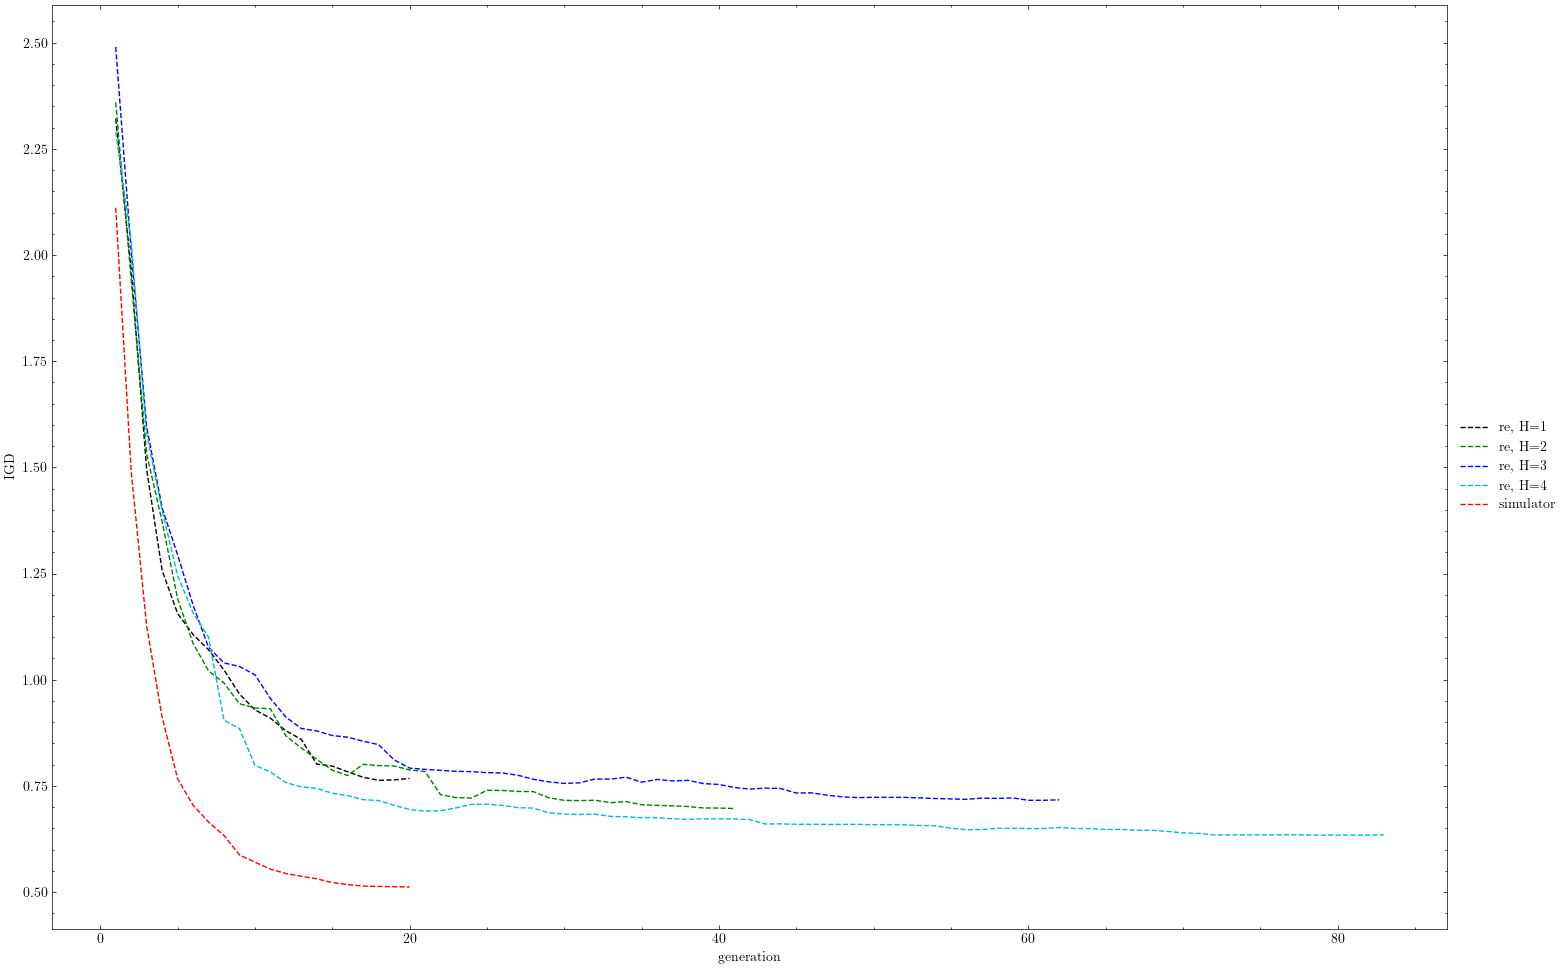

In [12]:
performance = []
marker = ['x', 'o', 's', 'v']
models = ['data12%', 'data25%', 'data50%', 'data100%']
colors = ['k', 'g', 'b', 'c']
# for cidx, key in enumerate(df.keys()):
plt.figure(figsize=(18,12))
for idx, generation in enumerate(generations):
    M = [i for i in range(1, int(generation))]
    using_H = H[idx]
    
    plt.plot(M, df[f'H={using_H}'], f'{colors[idx]}--', label=f're, H={using_H}')
    # plt.plot(M, df_surr[f'H={using_H}'], f'{colors[idx]}', label=f'surr, H={using_H}')
    # for idx, value in enumerate(df[key]):
    #  plt.scatter(M[idx], value, marker=marker[idx], label=models[idx], c=colors[cidx])
    performance.append(df[f'H={using_H}'])
plt.plot([i for i in range(1,21)],standard_data, linestyle='--', color='r', label='simulator')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("generation")
plt.ylabel("IGD")
plt.savefig(os.path.join('pic', 'plot_IGD_criterion_compare.png'), format='png', dpi=300, bbox_inches='tight')
plt.show()

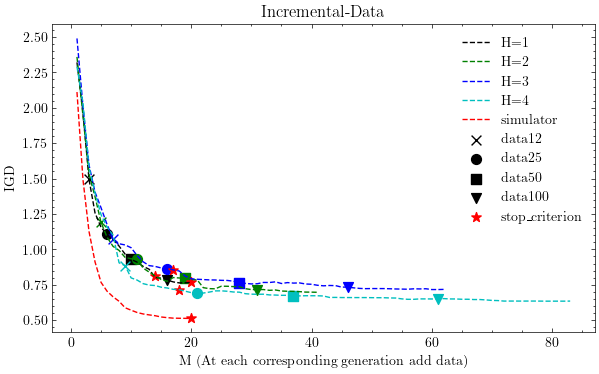

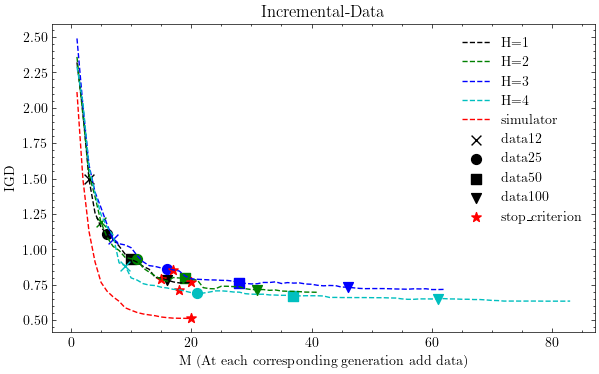

In [13]:
# stop_gen 
# reeval_IGD 
# used_th 
os.makedirs(os.path.join('pic', 'plot_IGD_criterion'), exist_ok=True)

size = 50
# for plot_idx in range(len(stop_gen_set)):
for plot_idx in range(1,3):
    performance = []
    marker = ['x', 'o', 's', 'v']
    models = ['data12%', 'data25%', 'data50%', 'data100%']
    colors = ['k', 'g', 'b', 'c']
    # for cidx, key in enumerate(df.keys()):
    plt.figure(figsize=(7,4))
    for idx, generation in enumerate(generations):
        M = [i for i in range(1, int(generation))]
        using_H = H[idx]
        
        plt.plot(M, df[f'H={using_H}'], f'{colors[idx]}--', label=f'H={using_H}')
        # for idx, value in enumerate(df[key]):
        #  plt.scatter(M[idx], value, marker=marker[idx], label=models[idx], c=colors[cidx])
        performance.append(df[f'H={using_H}'])
    plt.plot([i for i in range(1,21)],standard_data, linestyle='--', color='r', label='simulator')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    count = 0

    for cidx, generation in enumerate(generations):
        M = [i for i in range(1, int(generation))]
        using_H = H[cidx]
        for idx, value in enumerate(df[f'H={using_H}']):
            if idx == using_H*2:
                if count == 0:
                    plt.scatter(M[idx], value, marker='x', label='data12%', c=colors[cidx], s=size)
                else:
                    plt.scatter(M[idx], value, marker='x', c=colors[cidx], s=size)
            elif idx == using_H*5:
                if count == 0:
                    plt.scatter(M[idx], value, marker='o', label='data25%', c=colors[cidx], s=size)
                else:
                    plt.scatter(M[idx], value, marker='o', c=colors[cidx], s=size)
            elif idx == using_H*9:
                if count == 0:
                    plt.scatter(M[idx], value, marker='s', label='data50%', c=colors[cidx], s=size)
                else:
                    plt.scatter(M[idx], value, marker='s', c=colors[cidx], s=size)
            elif idx == using_H*15:
                if count == 0:
                    plt.scatter(M[idx], value, marker='v', label='data100%', c=colors[cidx], s=size)
                else:
                    plt.scatter(M[idx], value, marker='v', c=colors[cidx], s=size)

        count+=1

    # model_used = ['data100%', 'data50%', 'data25%', 'data12%']
    # for idx, each_performance in enumerate(new_performance):
    #     plt.plot([20,40,60,80,100], each_performance, label=model_used[idx])

    plt.scatter(stop_gen_set[plot_idx], reeval_IGD_set[plot_idx], marker="*", c='red', s=size, label='stop_criterion')

    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend()
    plt.ylabel('IGD')
    plt.xlabel('M (At each corresponding generation add data)')
    # plt.xticks(M, M)
    # plt.ylim(0.2,2)
    plt.title("Incremental-Data")
    plt.savefig(os.path.join('pic', 'plot_IGD_criterion', f'{used_th_set[plot_idx]}_IGD_criterion.png'), format='png', dpi=300, bbox_inches='tight')
    plt.show()

## SANER paper

## H = 1

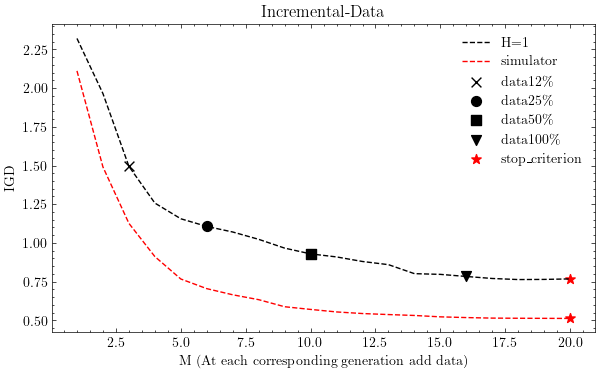

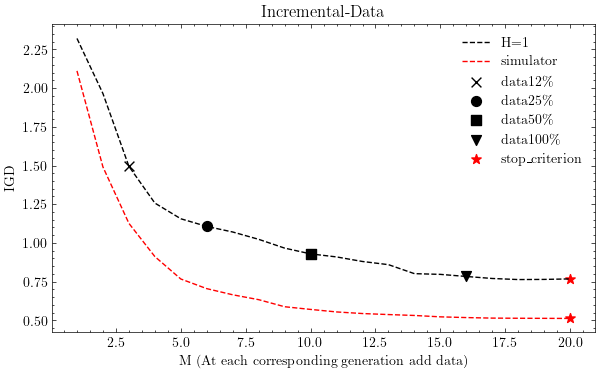

In [57]:
# stop_gen 
# reeval_IGD 
# used_th 
os.makedirs(os.path.join('pic', 'plot_IGD_criterion'), exist_ok=True)
# generations = ['20', '40', '60', '80']
generations = 20
using_H = 1
size = 50
# for plot_idx in range(len(stop_gen_set)):
for plot_idx in range(1,3):
    performance = []
    marker = ['x', 'o', 's', 'v']
    models = ['data12%', 'data25%', 'data50%', 'data100%']
    colors = ['k', 'g', 'b', 'c']
    # for cidx, key in enumerate(df.keys()):
    plt.figure(figsize=(7,4))
    
    idx = 0
    M = [i for i in range(1, generations+1)]
    plt.plot(M, df[f'H={using_H}'][:generations], f'{colors[idx]}--', label=f'H={using_H}')
    performance.append(df[f'H={using_H}'])
        
        
    plt.plot([i for i in range(1,21)],standard_data, linestyle='--', color='r', label='simulator')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  
    count = 0
    cidx = 0
    M = [i for i in range(1, generations+1)]
    for idx, value in enumerate(df[f'H={using_H}'][:generations]):
        if idx == using_H*2:
            if count == 0:
                plt.scatter(M[idx], value, marker='x', label='data12\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='x', c=colors[cidx], s=size)
        elif idx == using_H*5:
            if count == 0:
                plt.scatter(M[idx], value, marker='o', label='data25\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='o', c=colors[cidx], s=size)
        elif idx == using_H*9:
            if count == 0:
                plt.scatter(M[idx], value, marker='s', label='data50\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='s', c=colors[cidx], s=size)
        elif idx == using_H*15:
            if count == 0:
                plt.scatter(M[idx], value, marker='v', label='data100\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='v', c=colors[cidx], s=size)



    # model_used = ['data100%', 'data50%', 'data25%', 'data12%']
    # for idx, each_performance in enumerate(new_performance):
    #     plt.plot([20,40,60,80,100], each_performance, label=model_used[idx])

    plt.scatter([stop_gen_set[plot_idx][using_H-1], stop_gen_set[plot_idx][-1]] , [reeval_IGD_set[plot_idx][using_H-1], reeval_IGD_set[plot_idx][-1]], marker="*", c='red', s=size, label='stop_criterion')

    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend()
    plt.ylabel('IGD')
    plt.xlabel('M (At each corresponding generation add data)')
    # plt.xticks(M, M)
    # plt.ylim(0.2,2)
    plt.title("Incremental-Data")
    plt.savefig(os.path.join('pic', 'plot_IGD_criterion', f'{used_th_set[plot_idx]}_IGD_criterion.png'), format='png', dpi=300, bbox_inches='tight')
    plt.show()

## H = 2

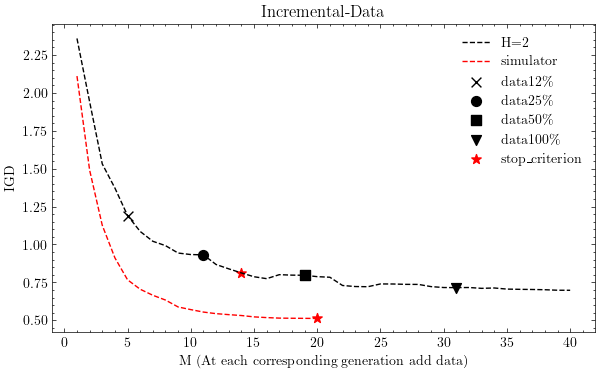

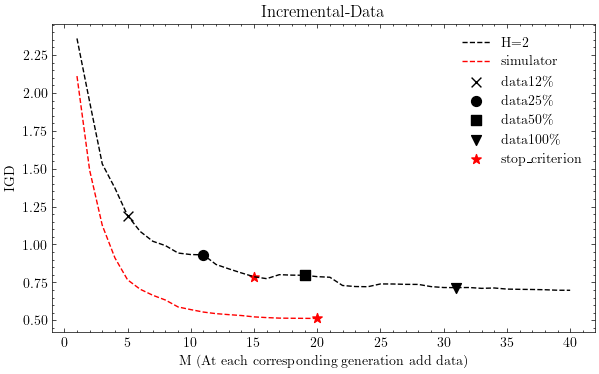

In [56]:
# stop_gen 
# reeval_IGD 
# used_th 
os.makedirs(os.path.join('pic', 'plot_IGD_criterion'), exist_ok=True)
# generations = ['20', '40', '60', '80']
generations = 40
using_H = 2
size = 50
# for plot_idx in range(len(stop_gen_set)):
for plot_idx in range(1,3):
    performance = []
    marker = ['x', 'o', 's', 'v']
    models = ['data12%', 'data25%', 'data50%', 'data100%']
    colors = ['k', 'g', 'b', 'c']
    # for cidx, key in enumerate(df.keys()):
    plt.figure(figsize=(7,4))
    
    idx = 0
    M = [i for i in range(1, generations+1)]
    plt.plot(M, df[f'H={using_H}'][:generations], f'{colors[idx]}--', label=f'H={using_H}')
    performance.append(df[f'H={using_H}'])
        
        
    plt.plot([i for i in range(1,21)],standard_data, linestyle='--', color='r', label='simulator')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  
    count = 0
    cidx = 0
    M = [i for i in range(1, generations+1)]
    for idx, value in enumerate(df[f'H={using_H}'][:generations]):
        if idx == using_H*2:
            if count == 0:
                plt.scatter(M[idx], value, marker='x', label='data12\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='x', c=colors[cidx], s=size)
        elif idx == using_H*5:
            if count == 0:
                plt.scatter(M[idx], value, marker='o', label='data25\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='o', c=colors[cidx], s=size)
        elif idx == using_H*9:
            if count == 0:
                plt.scatter(M[idx], value, marker='s', label='data50\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='s', c=colors[cidx], s=size)
        elif idx == using_H*15:
            if count == 0:
                plt.scatter(M[idx], value, marker='v', label='data100\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='v', c=colors[cidx], s=size)



    # model_used = ['data100%', 'data50%', 'data25%', 'data12%']
    # for idx, each_performance in enumerate(new_performance):
    #     plt.plot([20,40,60,80,100], each_performance, label=model_used[idx])

    plt.scatter([stop_gen_set[plot_idx][using_H-1], stop_gen_set[plot_idx][-1]] , [reeval_IGD_set[plot_idx][using_H-1], reeval_IGD_set[plot_idx][-1]], marker="*", c='red', s=size, label='stop_criterion')

    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend()
    plt.ylabel('IGD')
    plt.xlabel('M (At each corresponding generation add data)')
    # plt.xticks(M, M)
    # plt.ylim(0.2,2)
    plt.title("Incremental-Data")
    plt.savefig(os.path.join('pic', 'plot_IGD_criterion', f'{used_th_set[plot_idx]}_IGD_criterion.png'), format='png', dpi=300, bbox_inches='tight')
    plt.show()

## H = 3

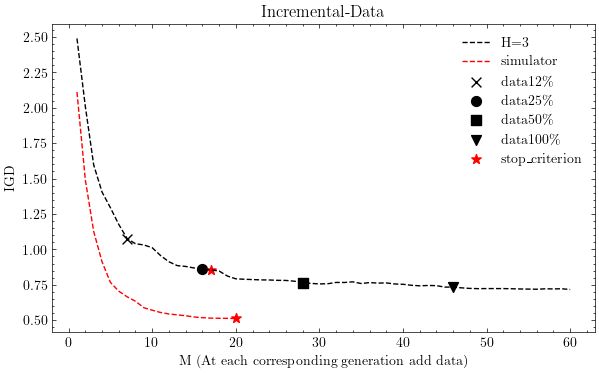

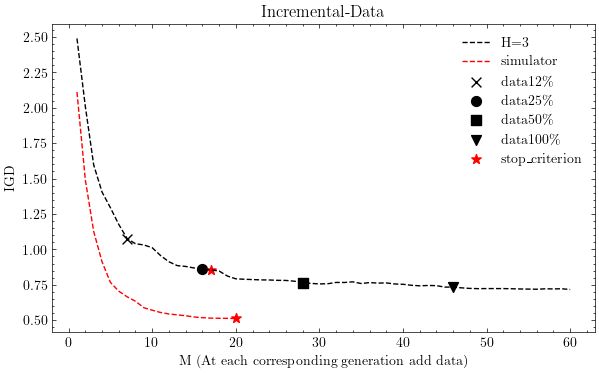

In [55]:
# stop_gen 
# reeval_IGD 
# used_th 
os.makedirs(os.path.join('pic', 'plot_IGD_criterion'), exist_ok=True)
# generations = ['20', '40', '60', '80']
generations = 60
using_H = 3
size = 50
save_plot_data = {}
# for plot_idx in range(len(stop_gen_set)):
for plot_idx in range(1,3):
    performance = []
    marker = ['x', 'o', 's', 'v']
    models = ['data12%', 'data25%', 'data50%', 'data100%']
    colors = ['k', 'g', 'b', 'c']
    # for cidx, key in enumerate(df.keys()):
    plt.figure(figsize=(7,4))
    
    idx = 0
    M = [i for i in range(1, generations+1)]
    plt.plot(M, df[f'H={using_H}'][:generations], f'{colors[idx]}--', label=f'H={using_H}')
    save_plot_data['M'] = M
    save_plot_data['H'] = df[f'H={using_H}'][:generations]
    performance.append(df[f'H={using_H}'])
        
        
    plt.plot([i for i in range(1,21)],standard_data, linestyle='--', color='r', label='simulator')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  
    count = 0
    cidx = 0
    M = [i for i in range(1, generations+1)]
    for idx, value in enumerate(df[f'H={using_H}'][:generations]):
        if idx == using_H*2:
            if count == 0:
                plt.scatter(M[idx], value, marker='x', label='data12\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='x', c=colors[cidx], s=size)
        elif idx == using_H*5:
            if count == 0:
                plt.scatter(M[idx], value, marker='o', label='data25\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='o', c=colors[cidx], s=size)
        elif idx == using_H*9:
            if count == 0:
                plt.scatter(M[idx], value, marker='s', label='data50\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='s', c=colors[cidx], s=size)
        elif idx == using_H*15:
            if count == 0:
                plt.scatter(M[idx], value, marker='v', label='data100\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='v', c=colors[cidx], s=size)



    # model_used = ['data100%', 'data50%', 'data25%', 'data12%']
    # for idx, each_performance in enumerate(new_performance):
    #     plt.plot([20,40,60,80,100], each_performance, label=model_used[idx])

    plt.scatter([stop_gen_set[plot_idx][using_H-1], stop_gen_set[plot_idx][-1]] , [reeval_IGD_set[plot_idx][using_H-1], reeval_IGD_set[plot_idx][-1]], marker="*", c='red', s=size, label='stop_criterion')

    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend()
    plt.ylabel('IGD')
    plt.xlabel('M (At each corresponding generation add data)')
    # plt.xticks(M, M)
    # plt.ylim(0.2,2)
    plt.title("Incremental-Data")
    plt.savefig(os.path.join('pic', 'plot_IGD_criterion', f'{used_th_set[plot_idx]}_IGD_criterion.png'), format='png', dpi=300, bbox_inches='tight')
    plt.show()

## H = 4

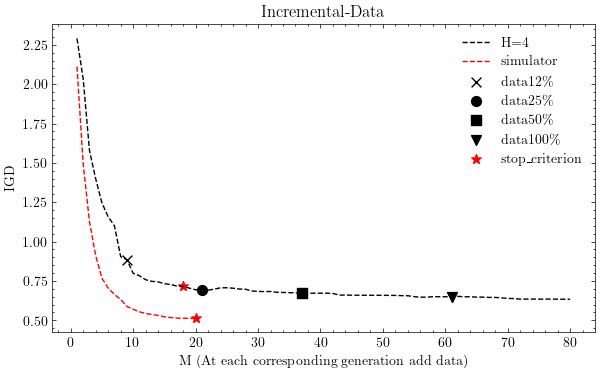

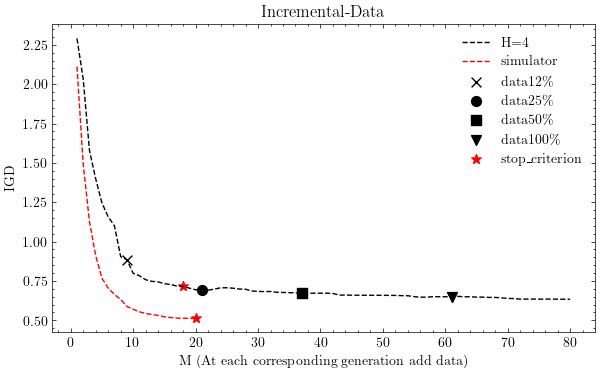

In [58]:
# stop_gen 
# reeval_IGD 
# used_th 
os.makedirs(os.path.join('pic', 'plot_IGD_criterion'), exist_ok=True)
# generations = ['20', '40', '60', '80']
generations = 80
using_H = 4
size = 50
# for plot_idx in range(len(stop_gen_set)):
for plot_idx in range(1,3):
    performance = []
    marker = ['x', 'o', 's', 'v']
    models = ['data12%', 'data25%', 'data50%', 'data100%']
    colors = ['k', 'g', 'b', 'c']
    # for cidx, key in enumerate(df.keys()):
    plt.figure(figsize=(7,4))
    
    idx = 0
    M = [i for i in range(1, generations+1)]
    plt.plot(M, df[f'H={using_H}'][:generations], f'{colors[idx]}--', label=f'H={using_H}')
    performance.append(df[f'H={using_H}'])
        
        
    plt.plot([i for i in range(1,21)],standard_data, linestyle='--', color='r', label='simulator')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  
    count = 0
    cidx = 0
    M = [i for i in range(1, generations+1)]
    for idx, value in enumerate(df[f'H={using_H}'][:generations]):
        if idx == using_H*2:
            if count == 0:
                plt.scatter(M[idx], value, marker='x', label='data12\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='x', c=colors[cidx], s=size)
        elif idx == using_H*5:
            if count == 0:
                plt.scatter(M[idx], value, marker='o', label='data25\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='o', c=colors[cidx], s=size)
        elif idx == using_H*9:
            if count == 0:
                plt.scatter(M[idx], value, marker='s', label='data50\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='s', c=colors[cidx], s=size)
        elif idx == using_H*15:
            if count == 0:
                plt.scatter(M[idx], value, marker='v', label='data100\%', c=colors[cidx], s=size)
            else:
                plt.scatter(M[idx], value, marker='v', c=colors[cidx], s=size)



    # model_used = ['data100%', 'data50%', 'data25%', 'data12%']
    # for idx, each_performance in enumerate(new_performance):
    #     plt.plot([20,40,60,80,100], each_performance, label=model_used[idx])

    plt.scatter([stop_gen_set[plot_idx][using_H-1], stop_gen_set[plot_idx][-1]] , [reeval_IGD_set[plot_idx][using_H-1], reeval_IGD_set[plot_idx][-1]], marker="*", c='red', s=size, label='stop_criterion')

    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend()
    plt.ylabel('IGD')
    plt.xlabel('M (At each corresponding generation add data)')
    # plt.xticks(M, M)
    # plt.ylim(0.2,2)
    plt.title("Incremental-Data")
    plt.savefig(os.path.join('pic', 'plot_IGD_criterion', f'{used_th_set[plot_idx]}_IGD_criterion.png'), format='png', dpi=300, bbox_inches='tight')
    plt.show()

In [21]:
data = pd.read_csv("stop_criterion.csv")
data

,standard_Stop_Generation,standard_reeval_IGD,standard_budget,H_1_Stop_Generation,H_1_reeval_IGD,H_1_budget,H_2_Stop_Generation,H_2_reeval_IGD,H_2_budget,H_3_Stop_Generation,H_3_reeval_IGD,H_3_budget,H_4_Stop_Generation,H_4_reeval_IGD,H_4_budget,delivery_rate_threshold,utilization_rate_threshold,num_risk_threshold,window
0,20,0.511861,252,20,0.767414,252,14,0.812298,126,16,0.864584,126,18,0.715462,63,-10.0,-10.0,-50.000000,10
1,20,0.511861,252,20,0.767414,252,14,0.812298,126,17,0.855049,126,18,0.715462,63,-10.0,-10.0,-47.894737,10
2,20,0.511861,252,20,0.767414,252,15,0.787107,126,17,0.855049,126,18,0.715462,63,-10.0,-10.0,-45.789474,10
3,20,0.511861,252,20,0.767414,252,15,0.787107,126,17,0.855049,126,18,0.715462,63,-10.0,-10.0,-43.684211,10
4,20,0.511861,252,20,0.767414,252,15,0.787107,126,18,0.847060,126,18,0.715462,63,-10.0,-10.0,-41.578947,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143995,20,0.511861,252,17,0.770080,252,16,0.774338,126,16,0.864584,126,13,0.747499,63,-0.1,-0.1,-18.421053,3
143996,20,0.511861,252,18,0.763117,252,16,0.774338,126,16,0.864584,126,13,0.747499,63,-0.1,-0.1,-16.315789,3
143997,20,0.511861,252,19,0.764070,252,16,0.774338,126,16,0.864584,126,13,0.747499,63,-0.1,-0.1,-14.210526,3
143998,20,0.511861,252,20,0.767414,252,20,0.787640,252,20,0.791855,126,13,0.747499,63,-0.1,-0.1,-12.105263,3


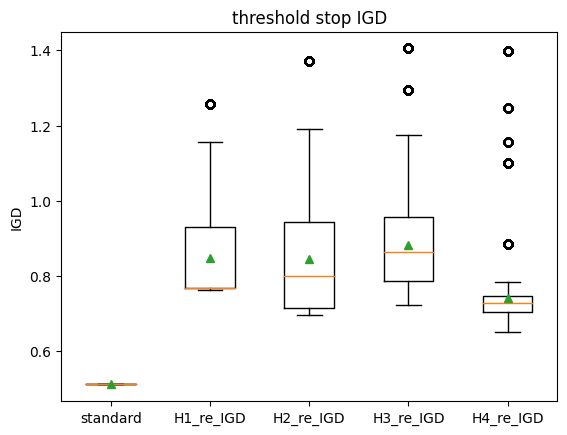

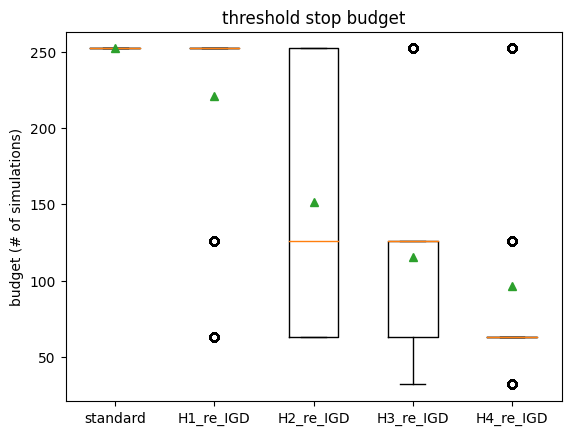

In [10]:
# data.boxplot(column=['standard_reeval_IGD', 'H_1_reeval_IGD', 'H_2_reeval_IGD', 'H_3_reeval_IGD', 'H_4_reeval_IGD'], grid=False, showmeans=True)
labels = ['standard', 'H1_re_IGD', 'H2_re_IGD', 'H3_re_IGD', 'H4_re_IGD']
plt.boxplot([data['standard_reeval_IGD'], data['H_1_reeval_IGD'], data['H_2_reeval_IGD'], data['H_3_reeval_IGD'], data['H_4_reeval_IGD']], labels=labels, showmeans=True)
plt.ylabel('IGD')
plt.title('threshold stop IGD')
plt.savefig(os.path.join('pic', 'plot_th_stop_IGD.png'), format='png', dpi=300, bbox_inches='tight')
plt.show()

plt.boxplot([data['standard_budget'], data['H_1_budget'], data['H_2_budget'], data['H_3_budget'], data['H_4_budget']], labels=labels, showmeans=True)
plt.ylabel('budget (# of simulations)')
plt.title('threshold stop budget')
plt.savefig(os.path.join('pic', 'plot_th_stop_budget.png'), format='png', dpi=300, bbox_inches='tight')
plt.show()

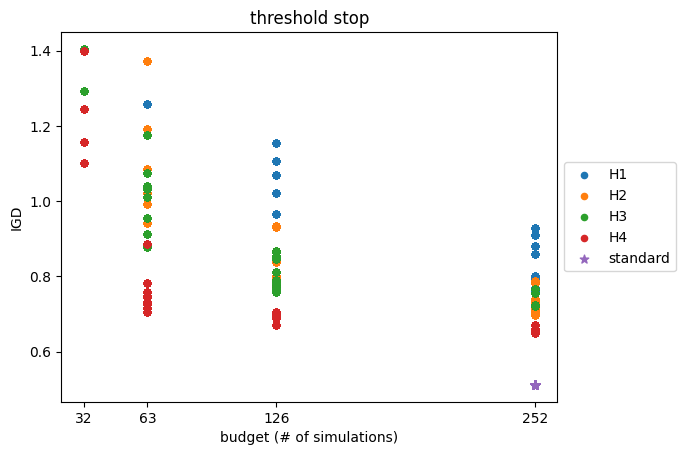

In [23]:
size = 20
plt.scatter(data['H_1_budget'], data['H_1_reeval_IGD'], label='H1', s=size)
plt.scatter(data['H_2_budget'], data['H_2_reeval_IGD'], label='H2', s=size)
plt.scatter(data['H_3_budget'], data['H_3_reeval_IGD'], label='H3', s=size)
plt.scatter(data['H_4_budget'], data['H_4_reeval_IGD'], label='H4', s=size)
plt.scatter(data['standard_budget'], data['standard_reeval_IGD'],  label='standard', s=size*2, marker="*")
plt.title('threshold stop')
plt.xlabel('budget (# of simulations)')
plt.ylabel('IGD')
plt.xticks([32,63,126,252], [32,63,126,252])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join('pic', 'plot_scattering.png'), format='png', dpi=300, bbox_inches='tight')
plt.show()

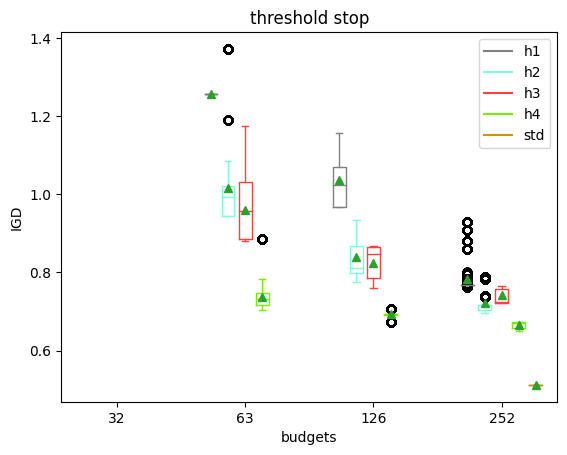

In [24]:
# the list named ticks, summarizes or groups
# the summer and winter rainfall as low, mid
# and high
ticks = [32,63,126,252]
budgets = [31,63,126,252]
 
# create a boxplot for two arrays separately,
# the position specifies the location of the
# particular box in the graph,
# this can be changed as per your wish. Use width
# to specify the width of the plot
# h1 = plt.boxplot([data[data['H_1_budget']==31], data[data['H_1_budget']==63], data[data['H_1_budget']==126], data[data['H_1_budget']==256]], positions=np.array(np.arange(len(ticks)))*5.0-0.35, widths=0.6)
# h2 = plt.boxplot([data[data['H_2_budget']==31], data[data['H_2_budget']==63], data[data['H_2_budget']==126], data[data['H_2_budget']==256]], positions=np.array(np.arange(len(ticks)))*5.0-0.35, widths=0.6)
# h3 = plt.boxplot([data[data['H_3_budget']==31], data[data['H_3_budget']==63], data[data['H_3_budget']==126], data[data['H_3_budget']==256]], positions=np.array(np.arange(len(ticks)))*5.0-0.35, widths=0.6)
widths = 0.3
h1 = plt.boxplot([data[data['H_1_budget']==31]['H_1_reeval_IGD'], data[data['H_1_budget']==63]['H_1_reeval_IGD'], 
                  data[data['H_1_budget']==126]['H_1_reeval_IGD'], data[data['H_1_budget']==252]['H_1_reeval_IGD']], 
                 positions=np.array(np.arange(len(ticks)))*3-0.8, widths=widths, showmeans=True)

h2 = plt.boxplot([data[data['H_2_budget']==31]['H_2_reeval_IGD'], data[data['H_2_budget']==63]['H_2_reeval_IGD'], 
                  data[data['H_2_budget']==126]['H_2_reeval_IGD'], data[data['H_2_budget']==252]['H_2_reeval_IGD']], 
                 positions=np.array(np.arange(len(ticks)))*3-0.4, widths=widths, showmeans=True)

h3 = plt.boxplot([data[data['H_3_budget']==31]['H_3_reeval_IGD'], data[data['H_3_budget']==63]['H_3_reeval_IGD'], 
                  data[data['H_3_budget']==126]['H_3_reeval_IGD'], data[data['H_3_budget']==252]['H_3_reeval_IGD']], 
                 positions=np.array(np.arange(len(ticks)))*3-0, widths=widths, showmeans=True)

h4 = plt.boxplot([data[data['H_4_budget']==31]['H_4_reeval_IGD'], data[data['H_4_budget']==63]['H_4_reeval_IGD'], 
                  data[data['H_4_budget']==126]['H_4_reeval_IGD'], data[data['H_4_budget']==252]['H_4_reeval_IGD']], 
                 positions=np.array(np.arange(len(ticks)))*3+0.4, widths=widths, showmeans=True)

std = plt.boxplot([data[data['standard_budget']==31]['standard_reeval_IGD'], data[data['standard_budget']==63]['standard_reeval_IGD'], 
                  data[data['standard_budget']==126]['standard_reeval_IGD'], data[data['standard_budget']==252]['standard_reeval_IGD']], 
                 positions=np.array(np.arange(len(ticks)))*3+0.8, widths=widths, showmeans=True)
# std = plt.boxplot([data[data['standard_budget']==31], data[data['standard_budget']==63], data[data['standard_budget']==126], data[data['standard_budget']==256]], positions=np.array(np.arange(len(ticks)))*5.0-0.35, widths=0.6)
 
# each plot returns a dictionary, use plt.setp()
# function to assign the color code
# for all properties of the box plot of particular group
# use the below function to set color for particular group,
# by iterating over all properties of the box plot
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
         
    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend()
 
 
# setting colors for each groups
define_box_properties(h1, '#808080', 'h1')
define_box_properties(h2, '#7FFFD4', 'h2')
define_box_properties(h3, '#FF4040', 'h3')
define_box_properties(h4, '#76EE00', 'h4')
define_box_properties(std, '#CD950C', 'std')
# define_box_properties(h2, '#2C7BB6', 'Winter')
 
# set the x label values
plt.xticks(np.arange(0, len(ticks) * 3, 3), ticks)
 
# set the limit for x axis
# plt.xlim(-2, len(ticks)*2)
 
# # set the limit for y axis
# plt.ylim(0, 50)
 
# set the title
plt.title('threshold stop')
plt.xlabel("budgets")
plt.ylabel("IGD")

plt.savefig(os.path.join('pic', 'plot_box_group.png'), format='png', dpi=300, bbox_inches='tight')
plt.show()

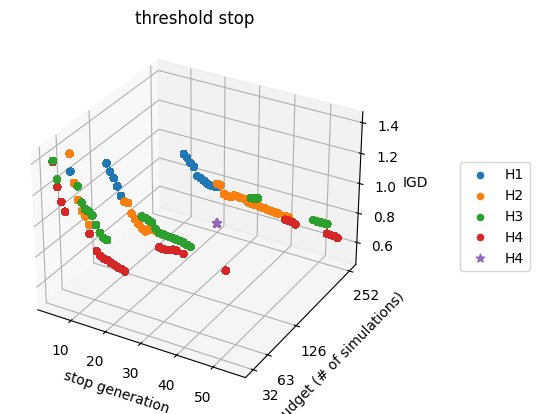

In [25]:
size = 20
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data['H_1_Stop_Generation'], data['H_1_budget'], data['H_1_reeval_IGD'],  label='H1', s=size)
ax.scatter(data['H_2_Stop_Generation'], data['H_2_budget'], data['H_2_reeval_IGD'],  label='H2', s=size)
ax.scatter(data['H_3_Stop_Generation'], data['H_3_budget'], data['H_3_reeval_IGD'],  label='H3', s=size)
ax.scatter(data['H_4_Stop_Generation'], data['H_4_budget'], data['H_4_reeval_IGD'],  label='H4', s=size)
ax.scatter(data['standard_Stop_Generation'], data['standard_budget'], data['standard_reeval_IGD'],  label='H4', s=size*2, marker="*")


ax.set_xlabel('stop generation')
ax.set_ylabel('budget (# of simulations)')
ax.set_yticks([32,63,126,252], [32,63,126,252])
ax.set_zlabel('IGD')

plt.title('threshold stop')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.savefig(os.path.join('pic', 'plot_scattering_3d.png'), format='png', dpi=300, bbox_inches='tight')
plt.show()